In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from PIL import Image

from rise.rise import RISE, IMAGES
import rise.utils as utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
model = model.to(device)

# Load black box model for explanations
model = models.resnet50(weights=weights)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval().cuda()


In [3]:
H, W = 224, 224
input_size = (H, W)

N = 4000      # number of masks (start small)
s = 7        # grid size
p = 0.1       # activation probability


test = RISE(model, (H, W))
#test.generate_masks(N, s, p)
test.load_masks()

In [4]:
img_path = IMAGES / "catdog.png"
img, x = utils.load_image_raw(img_path, device)

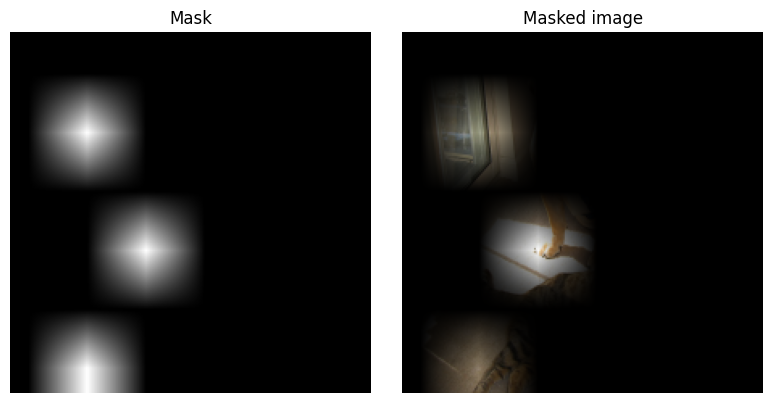

In [5]:
random_index = np.random.randint(N)
utils.draw_masked_image(img, test.masks[random_index])

In [6]:
with torch.no_grad():
    logits = model(x.float())
    class_id = logits.argmax(dim=1).item()
print(class_id)
class_name = weights.meta["categories"][class_id]
print(class_name)
print(logits[0, class_id].item())

243
bull mastiff
0.318499356508255


In [7]:
k = 5

with torch.no_grad():
    logits = model(x.float())
    values, indices = logits.topk(k, dim=1)
    values = values.cpu().numpy().squeeze()
    indices = indices.cpu().numpy().squeeze()

topk = [
    {
        "class_id": idx.item(),
        "class_name": weights.meta["categories"][idx],
        "logit": val.item(),
    }
    for idx, val in zip(indices, values)
]

topk

[{'class_id': 243, 'class_name': 'bull mastiff', 'logit': 0.318499356508255},
 {'class_id': 281, 'class_name': 'tabby', 'logit': 0.023587053641676903},
 {'class_id': 242, 'class_name': 'boxer', 'logit': 0.01899460144340992},
 {'class_id': 282, 'class_name': 'tiger cat', 'logit': 0.017291057854890823},
 {'class_id': 180,
  'class_name': 'American Staffordshire terrier',
  'logit': 0.01218151580542326}]

In [8]:
sal = test(x)

Running model: 100%|██████████| 40/40 [00:04<00:00,  8.45it/s]


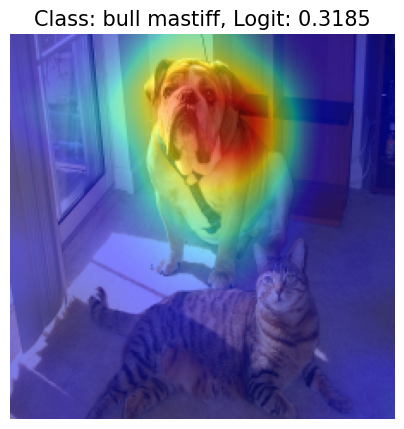

In [9]:
sal_map1 = sal[topk[0]["class_id"]]

# image (RGB)
img_np = np.array(img) / 255.0

# saliency map
sal_map_numpy = sal_map1.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.imshow(img_np)
plt.imshow(sal_map_numpy, cmap="jet", alpha=0.5)
plt.title(
    f"Class: {topk[0]['class_name']}, Logit: {topk[0]['logit']:.4f}",
    fontsize=15,
)
plt.axis("off")
plt.show()


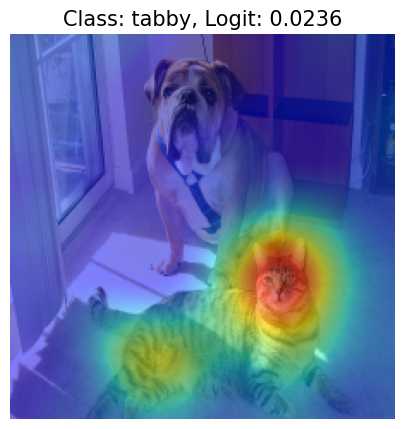

In [10]:
sal_map2 = sal[topk[1]["class_id"]]

# image (RGB)
img_np = np.array(img) / 255.0

# saliency map
sal_map_numpy = sal_map2.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.imshow(img_np)
plt.imshow(sal_map_numpy, cmap="jet", alpha=0.5)
plt.title(
    f"Class: {topk[1]['class_name']}, Logit: {topk[1]['logit']:.4f}",
    fontsize=15,
)
plt.axis("off")
plt.show()


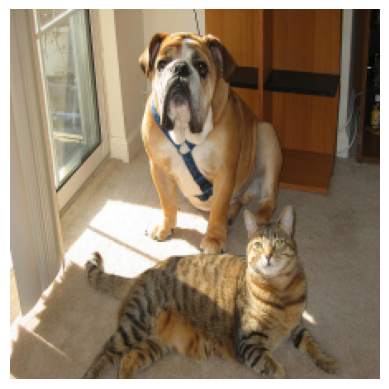

In [11]:
plt.imshow(img)
plt.axis("off")
plt.show()